<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/MultiphaseflowMeasurement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Multiphase flow measurements
#@markdown This document is part of the module ["Introduction to Gas Processing using NeqSim in Colab"](https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/examples_of_NeqSim_in_Colab.ipynb#scrollTo=_eRtkQnHpL70).
%%capture
!pip install neqsim
import neqsim
from neqsim.thermo.thermoTools import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy
import pandas as pd
%matplotlib inline

# Multiphase flow measurement
A multiphase flow meter is a device used to measure the individual phase flow rates of constituent phases in a given flow (for example in oil and gas industry) where oil, water and gas mixtures are initially co-mingled together during the oil production processes.

# Litterature

Wikipedia

https://en.wikipedia.org/wiki/Multiphase_flow_meter


HANDBOOK OF MULTIPHASE FLOW METERING:

https://nfogm.no/wp-content/uploads/2014/02/MPFM_Handbook_Revision2_2005_ISBN-82-91341-89-3.pdf

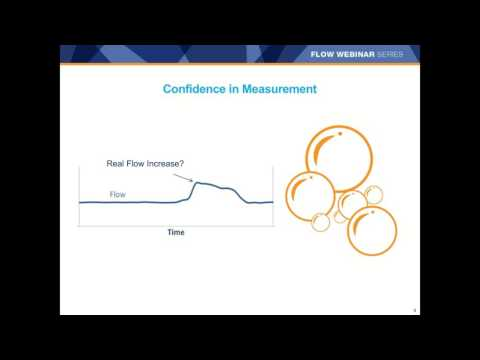

In [2]:
#@title Webinar: Advances in Multiphase Metering for Onshore Measurement in Oil & Gas
#@markdown This video gives an intriduction to Oil & Gas facilities Design
from IPython.display import YouTubeVideo
YouTubeVideo('mcxrjJwidl0', width=600, height=400)

# Generation of fluid characterization and generationg PVT properites for multi phase meters

In the following section it will be demonstrated how to generate PVT data for a multi phase flow meter. The steps in generation of PVT tables will be:


1. Collection of fluid composition and PVT data from a PVT report
2. Set up fluid composition based on compositional analysis in PVT report, calulate and compare to measured PVT properties from PVT report
3. Selection of parameters to fit, and fit model to PVT data
4. Gerenation of properties for multi phase flow meter

# 1. Collection of fluid composition and PVT data from PVTbreport. Evaluation of data.

We start by optaining a fluid composition and PVT data from a PVT report. Such data. THe fluid compositon can typically be reported based on samples from the test separator. The gas and oil from the test separator is analysed, and matehamtical recombined into a well stream composition.

Int the work we will assume that a well stream compostion as reported in the following composition. In this example we will use a fluid characterization based on a C10+ analysis. THe means that a detailed composition is used up to C6, and the C6, C7, C8 and C9 is defned as oil fraction components with properties calculated based on molar mass nnd density. C10+ is added with molar mass and density of the 10+ fraction.





In [3]:
definedComponents = ['nitrogen','CO2', 'methane', 'ethane', 'propane','i-butane','n-butane','i-pentane','n-pentane']
definedmolefractions = [0.972, 0.632, 95.111, 2.553, 0.104, 0.121, 0.021, 0.066, 0.02]
oilComponents = ["C6", "C7", "C8", "C9", "C10"]
oilComponentsMoleFractions= [0.058, 0.107, 0.073, 0.044, 0.118]
oilComponentsMolarMass = [86.18/1000.0, 96.0/1000.0, 107.0/1000.0, 121.0/1000.0, 202.0/1000.0] # kg/mol
oilComponentsRelativeDensity = [664.0e-3, 738.0e-3, 765.0e-3, 781.0e-3, 813.30e-3] #gr/cm3

#definedComponentArray = np.asarray([definedComponents,definedmolefractions,Zgas, isothermalcompressibility,liquidrelativevolume])
compositionDataFrame = pd.DataFrame(definedmolefractions,index=definedComponents, columns=["mole fraction"])
oilComponentsDataFrame = pd.DataFrame(numpy.transpose([oilComponentsMoleFractions, oilComponentsMolarMass, oilComponentsRelativeDensity]),index=oilComponents, columns=["mole fraction", "molar mass [kg/mole]", " density [gr/cm3]"])

print(compositionDataFrame.head(20).to_string())
print(oilComponentsDataFrame.head(20).to_string())


           mole fraction
nitrogen           0.972
CO2                0.632
methane           95.111
ethane             2.553
propane            0.104
i-butane           0.121
n-butane           0.021
i-pentane          0.066
n-pentane          0.020
     mole fraction  molar mass [kg/mole]   density [gr/cm3]
C6           0.058               0.08618             0.6640
C7           0.107               0.09600             0.7380
C8           0.073               0.10700             0.7650
C9           0.044               0.12100             0.7810
C10          0.118               0.20200             0.8133


## Data from PVT report
Typical data from a PVT report is reported in the following code. In the following example the fluid composition was reported based on test separarator data, and a constand mass expansion test was done (CME). Reservoir pressure and temperature.

    pressure  relative volume   Zgas  Density      Bg  gasexpansionfactor  gasviscosity
0      555.3           0.7410  1.247   0.2671  0.0027               365.6        0.0325
1      552.0           0.7431  1.244   0.2663  0.0027               364.6        0.0324
2      518.5           0.7660  1.204   0.2583  0.0028               353.7        0.0313
3      484.0           0.7917  1.162   0.2499  0.0029               342.2        0.0301
4      449.5           0.8210  1.119   0.2410  0.0030               330.0        0.0288
5      415.3           0.8551  1.077   0.2314  0.0032               316.8        0.0276
6      408.1           0.8631  1.068   0.2293  0.0032               313.9        0.0273
7      401.3           0.8710  1.060   0.2272  0.0032               311.0        0.0270
8      394.3           0.8795  1.051   0.2250  0.0032               308.0        0.0268
9      387.3           0.8883  1.043   0.2227  0.0033               305.0        0.0265
10     380.7           0.8972  1

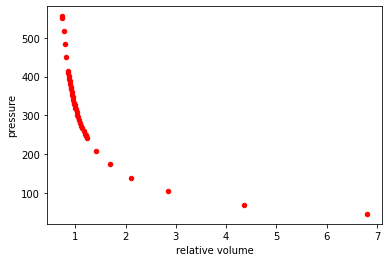

In [4]:
reservoirTemperature = 80.6 #Celius
reservoirPressure = 320.8 #bara

testSeparatorTemperature = 20.6 # Celcius
testSeparatorPressure = 86.8 # bara
GORseparartorConditions = 58959.0 # Sm3 gas//m3 condesate

GORstandardConditions = 55000.0 # Sm3 gas/Sm3 condesate


# Define a dictionary with PVT data
PVTdata = {'pressure':  [555.3,552,518.5,484,449.5,415.3,408.1,401.3,394.3,387.3,380.7,373.8,366.7,360,352.9,346.2,339.3,332.3,329.9,325.6,320,315.1,308.4,301.3,294.5,287.6,280.6,273.8,266.9,259.9,253.1,249.5,246.1,242.7,208.2,173.6,139,104.5,70,46.1], 
        'relative volume': [0.741,0.7431,0.766,0.7917,0.821,0.8551,0.8631,0.871,0.8795,0.8883,0.8972,0.9066,0.9169,0.9272,0.9385,0.9498,0.9621,0.9751,0.9797,0.9883,1,1.0105,1.0258,1.0428,1.0602,1.0787,1.0989,1.1197,1.1423,1.1668,1.1924,1.2064,1.2202,1.2346,1.4135,1.6806,2.1038,2.8422,4.3612,6.796],
        'Zgas': [1.247,1.244,1.204,1.162,1.119,1.077,1.068,1.06,1.051,1.043,1.035,1.027,1.019,1.012,1.004,0.997,0.99,0.982,0.98,0.976,0.97,0.965,0.959,0.952,0.946,0.941,0.935,0.929,0.924,0.919,0.915,0.912,0.91,0.908,0.892,0.884,0.887,0.9,0.926,0.95],
        'Density': [0.2671,0.2663,0.2583,0.2499,0.241,0.2314,0.2293,0.2272,0.225,0.2227,0.2206,0.2183,0.2158,0.2134,0.2108,0.2083,0.2057,0.2029,0.202,0.2002,0.1979,0.1958,0.1929,0.1898,0.1866,0.1834,0.1801,0.1767,0.1732,0.1696,0.1659,0.164,0.1622,0.1603,0.14,0.1177,0.0941,0.0696,0.0454,0.0291],
        'Bg': [0.0027,0.0027,0.0028,0.0029,0.003,0.0032,0.0032,0.0032,0.0032,0.0033,0.0033,0.0033,0.0034,0.0034,0.0035,0.0035,0.0036,0.0036,0.0036,0.0036,0.0037,0.0037,0.0038,0.0038,0.0039,0.004,0.0041,0.0041,0.0042,0.0043,0.0044,0.0045,0.0045,0.0046,0.0052,0.0062,0.0078,0.0105,0.0161,0.0251],
        'gasexpansionfactor': [365.6,364.6,353.7,342.2,330,316.8,313.9,311,308,305,302,298.8,295.5,292.2,288.7,285.2,281.6,277.8,276.5,274.1,270.9,268.1,264.1,259.8,255.5,251.1,246.5,241.9,237.2,232.2,227.2,224.6,222,219.4,191.7,161.2,128.8,95.3,62.1,39.9],
        'gasviscosity': [0.0325,0.0324,0.0313,0.0301,0.0288,0.0276,0.0273,0.027,0.0268,0.0265,0.0262,0.0259,0.0257,0.0254,0.0251,0.0248,0.0245,0.0243,0.0242,0.024,0.0237,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
        } 

# Convert the PVT data dictionary into DataFrame 
CMEdataFrame = pd.DataFrame(PVTdata) 
CMEpressures = CMEdataFrame['pressure'].tolist()
CMEtemperature = [80.6+273.15]*len(CMEpressures)

#print and plot the PVT data
print(CMEdataFrame.head(50).to_string())

print("plotting experimental PVT data.....")
CMEdataFrame.plot(kind='scatter',x='relative volume',y='pressure',color='red')
plt.show()



# 2. Set up fluid based on fluid composition and properties from PVT report, calculate and compare to measured PVT properties from PVT report

A fluid in neqsim is set up in the following script. We the flash the fluid to calculate the GOR at test separator and standard conditions. Further we will plot the phase envelope of the fluid.

## Setting up the fluid based on the PVT report
In the follwing script we create a neqsim fluid based on composition and data for oil components (molar mass and density) from the PVT report. We will then calcuate the phase envelope based on this fluid characterization.

phase envelope for characterized fluid


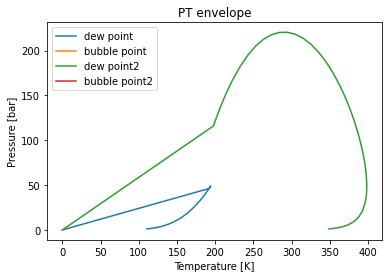

JavaObject id=o9

In [5]:
# Running PVTsimulation with default fluid
fluidDefinedComponents = createfluid2(definedComponents, definedmolefractions, "mol/sec")
characterizedFluid = addOilFractions(fluidDefinedComponents, oilComponents,oilComponentsMoleFractions, oilComponentsMolarMass,  oilComponentsRelativeDensity);
print('phase envelope for characterized fluid')
phaseenvelope(characterizedFluid, True)

## Compare neqsim calculations to data from PVT report
In the folllowing script we run neqsim simulations to compare how well the PVT data from the PVT report can be represented by the default fluid characterization. NeqSim will by default use SRK-EoS with Peneloux volume correction.

We start by comparing to measured GOR at separator and standard conditions.

In [6]:
characterizedFluid.setTemperature(15.0, "C")
characterizedFluid.setPressure(1.0, "atm")
TPflash(characterizedFluid)
#printFLuidCharacterisation(characterizedFluid) #print componentnames, TC, PC, acs, molar mass, density, 
printFrame(characterizedFluid)
GORcalcstd = characterizedFluid.getPhase("gas").getNumberOfMolesInPhase()*8.314*288.15/101325  / (characterizedFluid.getPhase("oil").getVolume("m3"))
print("GOR at standard conditions ", GORcalcstd, " Sm3 gas/m3 oil. ", " Deviation from PVT report: ", (GORcalcstd-GORstandardConditions)/GORstandardConditions*100, " %")

characterizedFluid.setTemperature(testSeparatorTemperature, "C")
characterizedFluid.setPressure(testSeparatorPressure, "bara")
TPflash(characterizedFluid)
GORcalc = characterizedFluid.getPhase("gas").getNumberOfMolesInPhase()*8.314*288.15/101325  / (characterizedFluid.getPhase("oil").getVolume("m3"))
print("GOR at test separator conditions: ", GORcalc, " Sm3 gas/m3 oil" , " Deviation from PVT report: ", (GORcalc-GORseparartorConditions)/GORseparartorConditions*100, " %")

#Calculating saturation pressure
#characterizedFluid.setTemperature(reservoirTemperature, "C")
#calcSatPres = saturationpressure(characterizedFluid)
#print("Saturation pressure : ", calcSatPres, " [bara]" , " Deviation from PVT report: ", (calcSatPres-reservoirPressure), " bar")

                          total         gas          oil                     
           nitrogen     9.72E-3  9.73446E-3   1.49001E-5      [mole fraction]
                CO2     6.32E-3  6.32925E-3   1.10201E-4      [mole fraction]
            methane   9.5111E-1  9.52519E-1   5.45759E-3      [mole fraction]
             ethane    2.553E-2  2.55666E-2   9.73661E-4      [mole fraction]
            propane     1.04E-3  1.04132E-3   1.56546E-4      [mole fraction]
           i-butane     1.21E-3   1.2111E-3   4.74008E-4      [mole fraction]
           n-butane      2.1E-4  2.10128E-4   1.24109E-4      [mole fraction]
          i-pentane      6.6E-4   6.5941E-4    1.0558E-3      [mole fraction]
          n-pentane        2E-4  1.99644E-4   4.38798E-4      [mole fraction]
              C6_PC      5.8E-4  5.68101E-4   8.56621E-3      [mole fraction]
              C7_PC     1.07E-3  1.01368E-3    3.8868E-2      [mole fraction]
              C8_PC      7.3E-4   6.3799E-4   6.24857E-2      [m

## Comparing to PVT data
In this case CME (constant mass expansion) experiments have been performed, and we will compare to these data.

    pressure  sim relative volume   Zgassim  densitysim     Bgsim  gasviscositysim
0      555.3             0.614402  1.287709  315.279358  0.002319         0.000040
1      552.0             0.615760  1.282886  314.572640  0.002324         0.000039
2      518.5             0.630535  1.233945  307.085764  0.002381         0.000038
3      484.0             0.647930  1.183617  298.715719  0.002448         0.000036
4      449.5             0.668101  1.133469  289.563895  0.002525         0.000035
5      415.3             0.691614  1.084085  279.578982  0.002615         0.000033
6      408.1             0.697107  1.073750  277.345100  0.002637         0.000033
7      401.3             0.702491  1.064014  275.189449  0.002657         0.000032
8      394.3             0.708247  1.054020  272.921992  0.002679         0.000032
9      387.3             0.714232  1.044057  270.603458  0.002702         0.000032
10     380.7             0.720098  1.034694  268.368740  0.002725         0.000031
11  

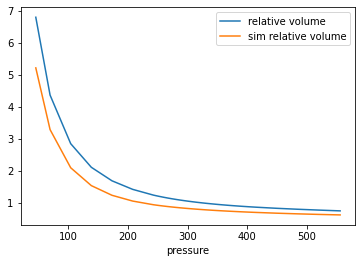

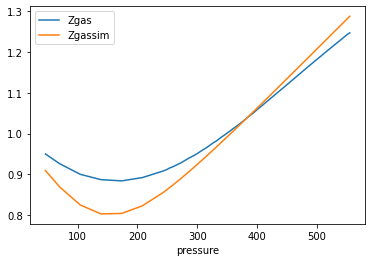

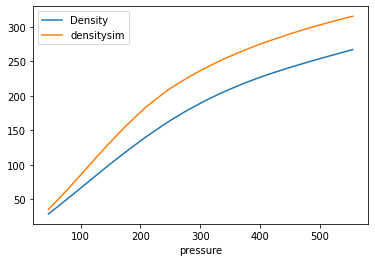

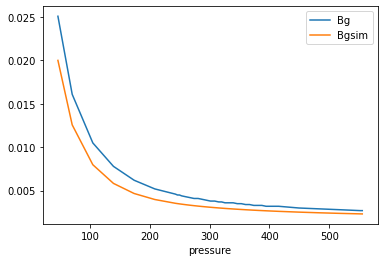

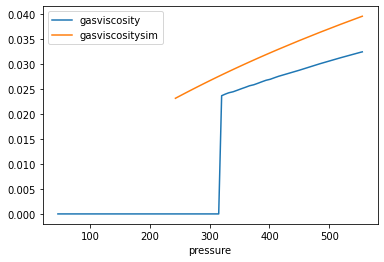

Deviation analysis...
Average deviation relative volume:  -21.615283377486772  %   Max devation  -17.08480506126552  %


In [7]:
simrelativevolume = []
simliquidrelativevolume = []
Zgas =  []
Bgsim=[]
densitysim =  []
Yfactor = []
isothermalcompressibility = []
gasviscositysim = []
saturationPressure = None
CME(characterizedFluid,CMEpressures,CMEtemperature,saturationPressure,simrelativevolume, simliquidrelativevolume,Zgas,Yfactor,isothermalcompressibility,densitysim,Bgsim, gasviscositysim)
CMEsimdataFrame = pd.DataFrame(numpy.transpose([CMEpressures, simrelativevolume,Zgas, densitysim, Bgsim, gasviscositysim]), columns=["pressure", "sim relative volume","Zgassim", "densitysim", "Bgsim", "gasviscositysim"])
print(CMEsimdataFrame.head(50).to_string())
print("saturation pressure simulated ", saturationPressure)
pd.concat([CMEdataFrame['pressure'], CMEdataFrame['relative volume'],CMEsimdataFrame['sim relative volume']],axis=1).plot(x='pressure')
pd.concat([CMEdataFrame['pressure'], CMEdataFrame['Zgas'],CMEsimdataFrame['Zgassim']],axis=1).plot(x='pressure')
pd.concat([CMEdataFrame['pressure'], CMEdataFrame['Density']*1e3,CMEsimdataFrame['densitysim']],axis=1).plot(x='pressure')
pd.concat([CMEdataFrame['pressure'], CMEdataFrame['Bg'],CMEsimdataFrame['Bgsim']],axis=1).plot(x='pressure')
pd.concat([CMEdataFrame['pressure'], CMEdataFrame['gasviscosity'],CMEsimdataFrame['gasviscositysim']*1e3],axis=1).plot(x='pressure',kind="line")

matplotlib.pyplot.show()

devanalysisframe = pd.concat([CMEdataFrame['pressure'], (CMEsimdataFrame['sim relative volume']-CMEdataFrame['relative volume'])/CMEdataFrame['relative volume']*100.0],axis=1)
print("Deviation analysis...")
print("Average deviation relative volume: ", devanalysisframe[0].mean(), " %", "  Max devation ", devanalysisframe[0].max() , " %")





# 3. Selection of parameters to fit, and fit model to PVT data
To be done...

# 4. Gerenation of properties for multi phase flow meter

A typical multi phase flow meter will need calclation of various thermodynamic and physical properties. SUch properties have to be updated s the field is produced. The input to the property calculations are a characterized fluid composition from PVT studies.

The following script demonstrates calculation of PVT properties for a multi phase flow meter using a Characterized fluid composition.

In [8]:
#Creating property tables
pressures = [150.0, 170.0, 180.0, 200.0, 270.0]
temperatures = [30.0, 40.0, 50.0, 60.0, 80.0]

numP = len(pressures)
numT = len(temperatures)

gasViscosity = numpy.zeros((numP, numT))
oilViscosity = numpy.zeros((numP, numT))
gasDensity = numpy.zeros((numP, numT))
oilDensity = numpy.zeros((numP, numT))
GORcalc  = numpy.zeros((numP, numT))
GORactual = numpy.zeros((numP, numT))
surfaceTension = numpy.zeros((numP, numT))
gasViscosity[:] = np.NaN
oilViscosity[:] = np.NaN
gasDensity[:] = np.NaN
oilDensity[:] = np.NaN
GORcalc[:] = np.NaN
GORactual[:] = np.NaN
surfaceTension[:] = np.NaN

for i in range(len(temperatures)):
  for j in range(len(pressures)):
    characterizedFluid.setPressure(pressures[j])
    characterizedFluid.setTemperature(temperatures[i]+273.15)
    TPflash(characterizedFluid)
    characterizedFluid.initProperties()
    if(characterizedFluid.hasPhaseType("gas")):
      gasViscosity[j][i]=characterizedFluid.getPhase("gas").getViscosity("cP")
      gasDensity[j][i]=characterizedFluid.getPhase("gas").getDensity("kg/m3")
    if(characterizedFluid.hasPhaseType("oil")):
      oilViscosity[j][i]=characterizedFluid.getPhase("oil").getViscosity("cP")
      oilDensity[j][i]=characterizedFluid.getPhase("oil").getDensity("kg/m3")
    if(characterizedFluid.hasPhaseType("gas") and characterizedFluid.hasPhaseType("oil")):
      GORcalc[j][i] = characterizedFluid.getPhase("gas").getNumberOfMolesInPhase()*8.314*288.15/101325  / (characterizedFluid.getPhase("oil").getVolume("m3"))
      GORactual[j][i] =   (characterizedFluid.getPhase("gas").getVolume("m3"))/ (characterizedFluid.getPhase("oil").getVolume("m3"))
      surfaceTension[j][i]  = characterizedFluid.getInterfacialTension('gas', 'oil')

gasDensityDataFrame = pd.DataFrame(gasDensity,index=pressures, columns=temperatures)
oilDensityDataFrame = pd.DataFrame(oilDensity,index=pressures, columns=temperatures)
gasviscosityDataFrame = pd.DataFrame(gasViscosity,index=pressures, columns=temperatures)
oilviscosityDataFrame = pd.DataFrame(oilViscosity,index=pressures, columns=temperatures)
GORcalcFrame = pd.DataFrame(GORcalc,index=pressures, columns=temperatures)
GORactualFrame = pd.DataFrame(GORactual,index=pressures, columns=temperatures)
surfaceTensionFrame= pd.DataFrame(surfaceTension,index=pressures, columns=temperatures)

print("gas density [kg/m3]")
print(gasDensityDataFrame.tail())
print("oil density [kg/m3]")
print(oilDensityDataFrame.head())
print("gas viscosity [(mPa.s)]")
print(gasviscosityDataFrame.tail())
print("oil viscosity [(mPa.s)]")
print(oilviscosityDataFrame.head())
#print("GOR (Sm3/m3)")
#print(GORcalcFrame.head())
print("GOR actual (m3/m3)")
print(GORactualFrame.head())
print("Surface Tension (N/m)")
print(surfaceTensionFrame.head())

gas density [kg/m3]
             30.0        40.0        50.0        60.0        80.0
150.0  121.631547  114.675424  108.678504  103.461393   94.869554
170.0  138.138954  130.255200  123.439032  117.505242  107.749027
180.0  146.135712  137.858369  130.683816  124.429936  114.036349
200.0  161.606503  152.676629  144.888931  138.075296  125.856176
270.0  205.659075  195.525279  186.288181  177.875860  163.217217
oil density [kg/m3]
             30.0        40.0        50.0        60.0        80.0
150.0  683.087959  684.612207  685.090347  684.494100  680.188710
170.0  673.764816  674.791606  674.841521  673.898457  669.118446
180.0  668.892621  669.716290  669.589093  668.499447         NaN
200.0  658.672473  659.189454  658.783942  657.454537         NaN
270.0         NaN         NaN         NaN         NaN         NaN
gas viscosity [(mPa.s)]
           30.0      40.0      50.0      60.0      80.0
150.0  0.016638  0.016545  0.016518  0.016541  0.016693
170.0  0.017745  0.017545  0.017